In [1]:
import numpy as np
import scipy.io
from pathlib import Path
import pandas as pd
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from functions import *

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
# Load .mat files
data_path = Path('D:/MATLAB_Analysis/Pre+process/Fncs/Run_tuning/testing_model_helper_fns/whisker_position_decoding_model/github_files/raw_data/E40')
params1 = scipy.io.loadmat(data_path / 'params.mat')
run_speed = scipy.io.loadmat(data_path / 'run_speed.mat')['run_speed']
SpikeTimes = scipy.io.loadmat(data_path / 'SpikeTimes.mat')['SpikeTimes']
trial_times = scipy.io.loadmat(data_path / 'trial_times.mat')
whisker_position = scipy.io.loadmat(data_path / 'whisker_position.mat')['whisker_position']
endT = trial_times['endT'];
startT = trial_times['startT'];
params = params1['params']
recording_endtime = params['recording_endtime'][0,0]
recording_fps = params['recording_fps'][0,0]
features = params['features'][0, 0]  #'features' is a field in actual_params
fps = features['fps'][0, 0]  # 'fps' is a field in features
vid_start_time = features['VidStartTime'][0, 0]  
vid_end_time = features['VidEndTime'][0, 0]
spike_params = params['spike'][0, 0]
exp_no = params['exp_no'][0,0]
Neuron_ID = spike_params['Neuron_ID'][0, 0]
spikeno_thresh_units = spike_params['spikeno_thresh_units'][0, 0]
stpt_amp_units = spike_params['stpt_amp_units'][0, 0]
run_units = spike_params['run_units'][0, 0]
phase_units = spike_params['phase_units'][0, 0]


In [3]:
# get bins for decoding whisker position
bin_res = 0.015
bins = np.arange(0, recording_endtime, bin_res)
# number of spike bins of size bin_res to used for decoding single feature bins
nBins = 11  # has to be an odd number 
VidStartTime = np.array([time[0] for time in vid_start_time])
VidEndTime = np.array([time[0] for time in vid_end_time])
# Select data between startT & endT
startT = trial_times['startT']
endT = trial_times['endT']
BOOL = [np.any((bin_value > startT) & (bin_value < endT)) for bin_value in bins]

In [4]:
# bin feature and neuron data
whisker_binned = get_features_in_timebins(bins, whisker_position, fps, VidStartTime, VidEndTime)
spike = np.array([np.histogram(SpikeTimes[n][0], bins)[0] / bin_res for n in range(Neuron_ID.shape[0])])

In [5]:
# select neurons
select_units = np.where(np.logical_or(stpt_amp_units,phase_units))[0]   
#all_units = np.arange(Neuron_ID.shape[0])
spike_select = spike[select_units, :]

In [6]:
# Decoding whisker position from all selected units
# generate design matrix
X_whisker, output_whisker, trial_start_idx, trial_end_idx = get_design_matrix(spike_select, whisker_binned, BOOL, nBins-1)
#find_alpha_ridge_regression(X,output_whisker)
testdata_whisker,preddata_whisker,model_whisker = perform_decoding(X_whisker, output_whisker, 2700)
r2_whisker,_,corr_coeff_whisker = get_errors(testdata_whisker,preddata_whisker)

R^2: 0.7353433915753085


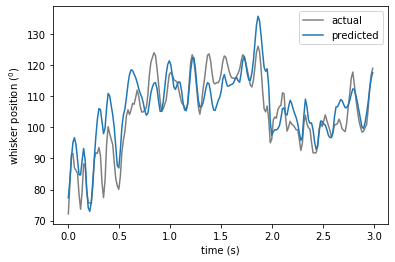

In [17]:
# PLor example trial
t_sec = 3
ii = np.random.randint(len(output_whisker)-t_sec*1/bin_res)
stop_idx = int(ii+t_sec*(1/bin_res))
x = np.arange(0,stop_idx-ii,1)*bin_res
whisker_pred = model_whisker.predict(X_whisker)
sigma = 1
plt.plot(x, gaussian_filter(output_whisker[ii:stop_idx], sigma=sigma), label='actual',color = 'black', alpha=.5)
plt.plot(x, gaussian_filter(whisker_pred[ii:stop_idx], sigma=sigma), label='predicted')
plt.xlabel('time (s)')
plt.ylabel('whisker position ($^0$)')
plt.legend()
plt.show()
#path = data_path / f'whisker_trace_e40_{ii}.svg'
#plt.savefig(path, format='svg')
#plt.close()

In [18]:
# Decoding whisker position as a function of number of neurons
N_steps = [5,7,10,15,20,25,30]
alpha = 2700
n_runs = 10
r2_whisker_nunits, corrcoeff_whisker_nunits = decoding_num_units(N_steps,n_runs,select_units,spike,whisker_binned,BOOL,nBins,alpha)

R^2: 0.2260169628848705
R^2: 0.23210379908212808
R^2: 0.25645223332936395
R^2: 0.2947516101114265
R^2: 0.2153201278014698
R^2: 0.03722198635674301
R^2: 0.4284364524126508
R^2: 0.33215535997933887
R^2: 0.3379320821271803
R^2: 0.15820806043508995
R^2: 0.3400614598578493
R^2: 0.3534545586448792
R^2: 0.31310039514610366
R^2: 0.2306586786425623
R^2: 0.2567379151323369
R^2: 0.295308225090282
R^2: 0.21332792407911905
R^2: 0.4390304286219805
R^2: 0.1775445868351131
R^2: 0.3945352302733085
R^2: 0.40570227442712026
R^2: 0.45364359701076795
R^2: 0.37856139972366676
R^2: 0.45149355143619485
R^2: 0.49181815132825024
R^2: 0.3157835916500593
R^2: 0.41021568640295347
R^2: 0.2616567063038997
R^2: 0.4601768941286746
R^2: 0.3196874045392254
R^2: 0.45218784385820543
R^2: 0.48696628032837785
R^2: 0.45460885453946476
R^2: 0.46831214225835416
R^2: 0.6095633159987504
R^2: 0.5063528117826833
R^2: 0.5632438956206114
R^2: 0.5638122650815113
R^2: 0.5587535673917525
R^2: 0.5372439212442182
R^2: 0.6297184433750784


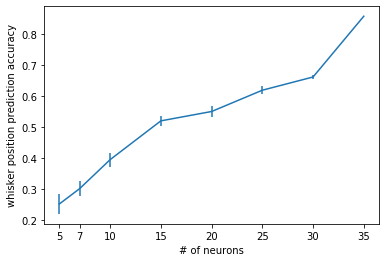

In [22]:
# Plot decoding accuracy as a function of number of units
mean_vals = np.mean(r2_whisker_nunits, axis=1)
sem_vals = np.std(r2_whisker_nunits, axis=1)/np.sqrt(n_runs)

import matplotlib.pyplot as plt

plt.errorbar(np.append(N_steps,35) ,np.append(mean_vals,corr_coeff_whisker), yerr=np.append(sem_vals,0))
plt.xlabel('# of neurons')
plt.ylabel('whisker position prediction accuracy')
plt.xticks(np.append(N_steps,35))
plt.show()

In [23]:
# Decoding run speed
# Different bin res for run speed
bin_res = 0.1
bins = np.arange(0, recording_endtime, bin_res)
# number of spike bins of size bin_res to used for decoding single feature bins
nBins = 9  # has to be an odd number 
VidStartTime = np.array([time[0] for time in vid_start_time])
VidEndTime = np.array([time[0] for time in vid_end_time])
BOOL = [np.any((bin_value > startT) & (bin_value < endT)) for bin_value in bins]
speed_binned = get_features_in_timebins(bins, run_speed, fps, VidStartTime, VidEndTime)
spike = np.array([np.histogram(SpikeTimes[n][0], bins)[0] / bin_res for n in range(Neuron_ID.shape[0])])

In [24]:
# select neurons
select_units = np.where(run_units)[0]   
spike_select = spike[select_units, :]
# Decoding Locomotion speed
X_speed, output_speed, trial_start_idx, trial_end_idx = get_design_matrix(spike_select, speed_binned, BOOL, nBins-1)
#find_alpha_ridge_regression(X_speed,output_speed)
testdata_speed,preddata_speed,model_speed = perform_decoding(X_speed, output_speed, 1800)
r2_speed,_,corr_coeff_speed = get_errors(testdata_speed,preddata_speed)

R^2: 0.7219205696802546


1501


"\npath = data_path / f'run_trace E-{exp_no[0][0]},bin_res={bin_res},nbins={nBins},R2={r2_speed},{ii}.svg'\nplt.savefig(path, format='svg')\nplt.close()\n"

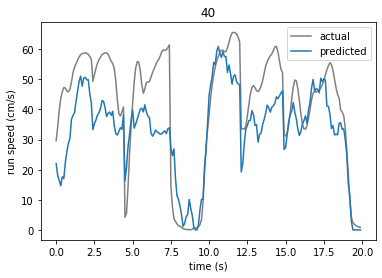

In [27]:
# PLor example trial
t_sec = 20
ii = np.random.randint(len(output_speed)-t_sec*1/bin_res)
print(ii)
stop_idx = int(ii+t_sec*(1/bin_res))
x = np.arange(0,stop_idx-ii,1)*bin_res
speed_pred = model_speed.predict(X_speed)
speed_pred[speed_pred<0]=0

plt.plot(x, output_speed[ii:stop_idx], label='actual',color = 'black', alpha=.5)
plt.plot(x, gaussian_filter(speed_pred[ii:stop_idx], sigma = 0), label='predicted')
plt.xlabel('time (s)')
plt.ylabel('run speed (cm/s)')
#plt.ylim([0,40])
plt.title(exp_no[0][0])
plt.legend()#plt.show()

'''
path = data_path / f'run_trace E-{exp_no[0][0]},bin_res={bin_res},nbins={nBins},R2={r2_speed},{ii}.svg'
plt.savefig(path, format='svg')
plt.close()
'''

In [28]:
# Decoding performance based on number of neurons
N_steps = [5,7,10,15,20,25,30]
alpha = 1800
n_runs = 10
r2_speed_nunits, corrcoeff_speed_nunits = decoding_num_units(N_steps,n_runs,select_units,spike,speed_binned,BOOL,nBins,alpha)

R^2: 0.38429151519391247
R^2: 0.38660575078193093
R^2: 0.4938070289958215
R^2: 0.525966375055523
R^2: 0.5336312271797756
R^2: 0.2034033212815759
R^2: 0.4925518238829283
R^2: 0.31594940404889416
R^2: 0.44297572316785394
R^2: 0.5131370031226534
R^2: 0.3368547003811946
R^2: 0.5116282586697853
R^2: 0.560643993869103
R^2: 0.6333771788067788
R^2: 0.5423542157428785
R^2: 0.5909743286636242
R^2: 0.42701622140880613
R^2: 0.5300834547547308
R^2: 0.4021250575470492
R^2: 0.5456549842847763
R^2: 0.51769287565898
R^2: 0.5965106429258213
R^2: 0.5975239795661791
R^2: 0.5749538844719697
R^2: 0.5407274767627122
R^2: 0.6290404222010775
R^2: 0.598848718321074
R^2: 0.6638745085347987
R^2: 0.6149785464562654
R^2: 0.6127172445832723
R^2: 0.6661880540619647
R^2: 0.682581966898383
R^2: 0.6820687841732602
R^2: 0.6873851888727358
R^2: 0.6937036972589097
R^2: 0.7045568684454868
R^2: 0.7055607961509875
R^2: 0.6743163073808442
R^2: 0.6285173057156226
R^2: 0.6966107522109297


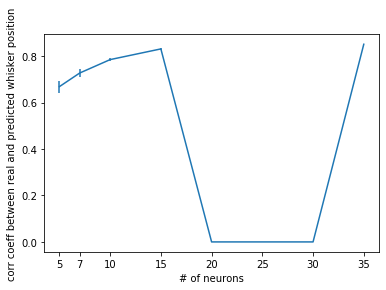

In [29]:
# Plot decoding accuracy as a function of number of units
mean_vals = np.mean(corrcoeff_speed_nunits, axis=1)
sem_vals = np.std(corrcoeff_speed_nunits, axis=1)/np.sqrt(n_runs)

import matplotlib.pyplot as plt

plt.errorbar(np.append(N_steps,35) ,np.append(mean_vals,corr_coeff_speed), yerr=np.append(sem_vals,0))
plt.xlabel('# of neurons')
plt.ylabel('corr coeff between real and predicted whisker position')
plt.xticks(np.append(N_steps,35))
plt.show()